## A simple noisy simulator

In [1]:
import itertools

import numpy as np
from tools import Circuit, gate_dic
from state_vector_qpu import State, StateVectorQPU


def make_depol_kraus_ops(prob, nqbits):
    """function that returns the Kraus operators of depolarizing noise"""
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)
    k_ops = [np.sqrt(1 - 3 / 4 * prob) * np.identity(2),
             np.sqrt(prob / 4) * X,
             np.sqrt(prob / 4) * Y,
             np.sqrt(prob / 4) * Z]
    if nqbits == 2:
        pauli_matrices = [np.eye(2), X, Y, Z]
        unweighted_k_ops = [np.kron(p1, p2) for p1, p2 in itertools.product(pauli_matrices, repeat=2)]
        weight_non_id_kraus_op = np.sqrt(prob / 16)  # adjusted so that the channel is TP
        coeffs = [np.sqrt(1 - 15 / 16 * prob)] + 15 * [weight_non_id_kraus_op]
        k_ops = [coeff * unweighted_k_op for coeff, unweighted_k_op in zip(coeffs, unweighted_k_ops)]

    return k_ops

class NoisyQPU:
    """
    Noisy QPU that puts depolarizing noise after each gate
    
    Args:
        nqbits (int): number of qubits to act on
        gate_dic (dic): the dictionary with the gate definitions (in terms of unitary matrices)
        depol_prob_1 (float): depolarization probability for one-qubit gates
        depol_prob_2 (float): depolarization probability for two-qubit gates
        
    The depolarizing channel is defined as:
        N(rho) = (1-p) rho + p I/2^n.

    """
    def __init__(self, nqbits, gate_dic, depol_prob_1=0.0, depol_prob_2=0.0):
        self.nqbits = nqbits
        self.state = State(2*nqbits) # now this is |rho>> corresponding to |0,0..><0,0..|
        
        self.gate_dic = {}
        for name, gate in gate_dic.items():
            if callable(gate):
                self.gate_dic[name] = lambda param : np.kron(gate(param), np.conj(gate(param)))
            else:
                self.gate_dic[name] = np.kron(gate, np.conj(gate))
                         
        self.depol_mat_1 = None
        if depol_prob_1>0.0:
            kraus_list = make_depol_kraus_ops(depol_prob_1, 1)
            self.depol_mat_1 = sum([np.kron(kraus, np.conj(kraus)) for kraus in kraus_list])
            
        self.depol_mat_2 = None
        if depol_prob_2>0.0:
            kraus_list = make_depol_kraus_ops(depol_prob_2, 2)
            self.depol_mat_2 = sum([np.kron(kraus, np.conj(kraus)) for kraus in kraus_list])
                    
    def submit(self, circuit):
        assert(circuit.nqbits == self.nqbits)
        for gate_tuple in circuit.gates:
            matrix = self.gate_dic[gate_tuple[0]] if len(gate_tuple)==2\
                        else self.gate_dic[gate_tuple[0]](gate_tuple[2])
            qbits = gate_tuple[1] + [qb + self.nqbits for qb in gate_tuple[1]]
            self.state.apply(matrix, qbits)
            
            # now apply noise
            if len(gate_tuple[1]) == 1 and self.depol_mat_1 is not None:
                self.state.apply(self.depol_mat_1, qbits)
                
            if len(gate_tuple[1]) == 2 and self.depol_mat_2 is not None:
                self.state.apply(self.depol_mat_2, qbits)
                
            
        return self.state
    
circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])
qpu = NoisyQPU(2, gate_dic)

res_state = qpu.submit(circ)
rho = res_state.to_vec().reshape((4, 4))
psi_expect = np.array([1, 0, 0, 1])/np.sqrt(2)
rho_expect = np.outer(psi_expect, psi_expect)
assert(np.linalg.norm(rho-rho_expect)<1e-12)

## Simple tests

In [2]:
circ = Circuit(1, [("H", [0])])
prob = 0.1
qpu = NoisyQPU(1, gate_dic, depol_prob_1=prob)

res_state = qpu.submit(circ)
rho = res_state.to_vec().reshape((2, 2))
psi_expect = np.array([1, 1])/np.sqrt(2)
rho_expect = (1-prob) * np.outer(psi_expect, psi_expect) + prob*np.identity(2)/2.

assert(np.linalg.norm(rho-rho_expect)<1e-12)


circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])
prob = 0.1
qpu = NoisyQPU(2, gate_dic, depol_prob_1=0.0, depol_prob_2=prob)

res_state = qpu.submit(circ)
rho = res_state.to_vec().reshape((4, 4))
psi_expect = np.array([1, 0, 0, 1])/np.sqrt(2)
rho_expect = (1-prob) * np.outer(psi_expect, psi_expect) + prob*np.identity(4)/4.

assert(np.linalg.norm(rho-rho_expect)<1e-12)

### Application: Randomized benchmarking

In [3]:
import random


def perform_rb(sequence_lengths, qpu, n_samples=20):

    fid_list = []
    for length in sequence_lengths:
        fids = []
        for _ in range(n_samples):
            gates = [(random.choice(["X", "Y", "Z", "H", "S"]), [0]) for _ in range(length)]
            gates += [(gate+"dag" if gate == "S" else gate, qbits) for gate, qbits in reversed(gates)]
            circ = Circuit(1, gates)
            res_state = qpu.submit(circ)
            rho = res_state.to_vec().reshape((2, 2))
            fids.append(rho[0, 0]) # p(0)
        fid_list.append(np.mean(fids))
    return fid_list

/usr/local/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib64/python3.9/site-packages/numpy/lib/function_base.py:625: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


[0.5 1. ]
[0.74095634 0.74882746]
[0.85769738 0.6275528 ]
[1.18375733 0.44843132]


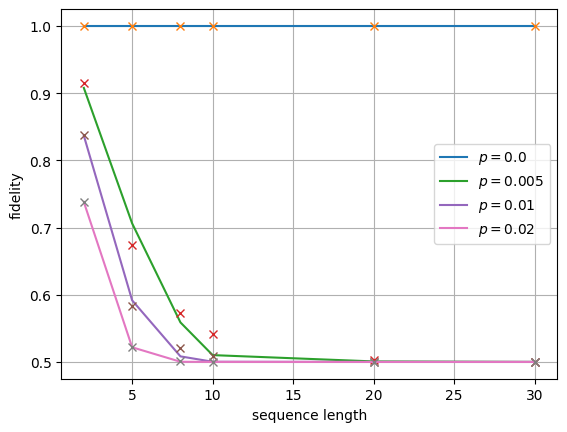

In [4]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_func(x, a, p):
    """a p^n + 0.5"""
    return a*np.exp(x*np.log(p))+0.5

prob_list = [0.0, 0.005, 0.01, 0.02]

coeff_list = []
for prob in prob_list:
    qpu = NoisyQPU(1, gate_dic, depol_prob_1=prob)
    sequence_lengths = [2, 5, 8, 10, 20, 30]
    fid_list = perform_rb(sequence_lengths, qpu)

    #print(prob, fid_list)

    sequence_lengths = np.array(sequence_lengths)
    fid_list = np.array(fid_list)

    plt.plot(sequence_lengths, fid_list, label=f"$p = {prob}$")

    xopt, xcov = curve_fit(fit_func, sequence_lengths, fid_list)
    print(xopt)
    coeff_list.append(xopt[1])

    plt.plot(sequence_lengths, fit_func(sequence_lengths, *xopt), 'x', lw=2, label=None)

plt.xlabel("sequence length")
plt.ylabel("fidelity")
plt.legend()
plt.grid();

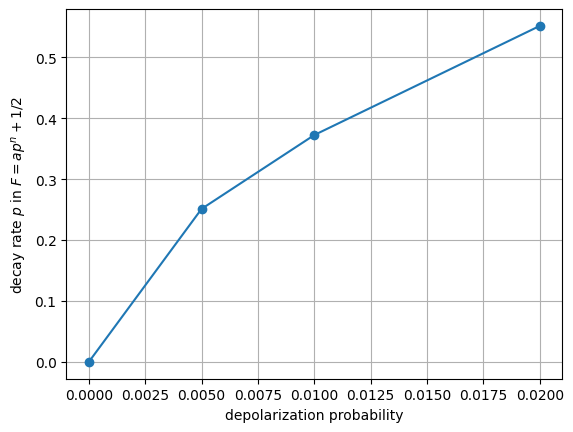

In [5]:
plt.plot(prob_list, 1-np.array(coeff_list), '-o')
plt.grid()
plt.xlabel("depolarization probability")
plt.ylabel(r"decay rate $p$ in $F = a p^n + 1/2$");